In [349]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import os
import sys
import IPython
from PIL import Image
import multiprocessing
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np # linear algebra
from scipy.spatial import distance_matrix
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorboard
import tensorflow.keras.backend as K
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, SpatialDropout2D, \
                                    ZeroPadding2D, GaussianNoise, Softmax, \
                                    Input, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import preprocess_input
tf.keras.backend.set_floatx('float64')

In [350]:
# backbone_model = tf.keras.applications.MobileNetV2(input_shape=self.input_shape, \
#                                                    alpha=1.0, include_top=False, weights='imagenet', pooling='avg')
# middle_model  = Model(name="middle_model", 
#                       inputs=backbone_model.input, 
#                       outputs=backbone_model.get_layer("block_3_depthwise_relu").output)
# middle_model.trainable = False
# x = GlobalAveragePooling2D()(x)

In [351]:
COLOR = {"red": [234, 15, 25],
         "black": [8, 30, 7],
         "white": [224, 250, 248],
         "yellow": [237, 229, 36],
         "orange": [245, 204, 0],
         "grey": [129, 121, 137],
         "purple": [153, 0, 204],
         "green": [51, 214, 51],
         "pink": [266, 142, 204],
         "brown": [153, 102, 0], 
         "blue": [102, 102, 255],
         "marine": [8, 158, 170]}

## Policy

In [352]:
#             #forward pass
#             a_dist = logits.numpy()
#             # Choose random action with p = action dist
#             if np.random.uniform() < self.explor_proba:
#                 # randomization of action
#                 a = np.random.choice([0, 1, 2])
#             else: # choose a legitimate action
#                 a = np.random.choice(a_dist[0], p=a_dist[0])
#                 a = np.argmax(a_dist == a)

In [354]:
class PolicyNN:
    """ Policy Neural Network object
    """
    
    def __init__(self, env, name):
        self.model_config = {"dropout": 0.2,
                             "kernel_init": 'he_normal',
                             "kernel_constraint": max_norm(4.0)}
        self.regul_config = {"rc_importance": 1,
                             "rc_d": 2}
        self.lr_config = {"initial_lr": 1e-4,
                          "n_learning_step_before_reduce": 250,
                          "final_lr": 1e-7,
                          "prod_decay_lr": 0.999,
                          "momentum": 0.9}
        self.exploration_config = {"n_learning_step_before_reduce": 1500,
                                   "initial_value": 0.5,
                                   "final_value": 0.1,
                                   "cst_decay": 0.0025}
        self.explor_proba = self.exploration_config["initial_value"]
        self.name = name
        self.model_h5_path = 'models/policy-model-'+env.nn_input_mode+"-"+str(self.name)+'.h5'
        self.tf_writer = tf.summary.create_file_writer("tf-logs/"+env.nn_input_mode+"-"+str(self.name))
        self.output_size = 3
        self.nn_input_shape = env.nn_input_config[env.nn_input_mode]["shape"]
        if os.path.exists(self.model_h5_path):
            print("LOAD a pre-trained model...")
            self.model = load_model(self.model_h5_path)
        else:
            print("INITIALIZE a new model...")
            self.model = self.init_model()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=self.lr_config["initial_lr"])
        self.loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
        
        self.grad_buffer = self.model.trainable_variables
        self._reset_grad_buffer()
        
    def _reset_grad_buffer(self):
        for ix, grad in enumerate(self.grad_buffer):
            self.grad_buffer[ix] = grad * 0
        

    def init_model(self):
        nn_input = Input(shape=self.nn_input_shape)
        x = Dropout(rate=self.model_config["dropout"])(nn_input)
        x = Dense(128, activation='relu', kernel_initializer=self.model_config["kernel_init"], 
                      kernel_constraint=self.model_config["kernel_constraint"], name='dense1')(x)
        x = Dropout(rate=self.model_config["dropout"])(x)
        x = Dense(128, activation='relu', kernel_initializer=self.model_config["kernel_init"], 
                      kernel_constraint=self.model_config["kernel_constraint"], name='dense2')(x)
        x = Dropout(rate=self.model_config["dropout"])(x)
        x = Dense(self.output_size, activation='relu', \
                    kernel_initializer=self.model_config["kernel_init"], 
                  kernel_constraint=self.model_config["kernel_constraint"], name='dense4_softmax')(x)
        output = Softmax()(x)
        return Model(name="PolicyNN", inputs=nn_input, outputs=output)
    
    def _update_explor_proba(self, learning_step):
        if learning_step > self.exploration_config["n_learning_step_before_reduce"] and \
                self.explor_proba > self.exploration_config["final_value"]:
            self.explor_proba -= self.exploration_config["cst_decay"]
    
    def _update_lr(self, learning_step):
        if learning_step > self.lr_config["n_learning_step_before_reduce"] and \
                self.optimizer.lr.read_value().numpy() > self.lr_config["final_lr"]:
            self.optimizer.lr.assign(self.optimizer.lr.read_value().numpy()*self.lr_config["prod_decay_lr"])
    
#     @tf.function
    def __call__(self, nn_input):
        with tf.GradientTape() as tape:
            # forward pass
            logits = self.model(nn_input)
            if tf.random.uniform([]) < self.explor_proba: # randomization of action
                a = tf.random.uniform([], minval=0, maxval=3, dtype=tf.dtypes.int32)
            else: # choose a legitimate action
                a = tf.random.categorical(tf.math.log(logits), 1)[0, 0]
            try: # compute the loss value
                loss = self.loss([a], logits)
                loss_wr = self.model.losses
                loss_rc =  self.regul_config['rc_importance']*tf.math.abs(logits-1/len(logits))**self.regul_config['rc_d']
            except:
                raise RuntimeError("Error caught on loss computation :", logits, a, loss)
        gradients = tape.gradient(loss, self.model.trainable_variables)
        return a, logits, gradients
    
    def summary(self, score, length, confidence, state, choices, step):
        with self.tf_writer.as_default():
            tf.summary.scalar("metric/score", score, step=step)
            tf.summary.scalar("metric/length", length, step=step)
            tf.summary.scalar("metric/state", state, step=step)
            tf.summary.scalar("behaviour/confidence", confidence, step=step)
            tf.summary.scalar("behaviour/straight", choices[0], step=step)
            tf.summary.scalar("behaviour/left", choices[1], step=step)
            tf.summary.scalar("behaviour/right", choices[2], step=step)
            tf.summary.scalar("config/exploration", self.explor_proba, step=step)
            tf.summary.scalar("config/lr", self.optimizer.lr.read_value(), step=step)
        self._update_explor_proba(learning_step=step)
        self._update_lr(learning_step=step)
            
    
#     @tf.function
    def backpropagate(self):
        self.optimizer.apply_gradients(zip(self.grad_buffer, self.model.trainable_variables))
        self._reset_grad_buffer()
        
    def save(self):
        self.model.save(self.model_h5_path)

## Environment

In [355]:
class Environment:
    # we consider grid values standardized in [0, 1]
    # we consider grid colors in RGB in lists such as [0, 128, 255]
    
    def __init__(self,
                 n_row=9, 
                 n_col=9,
                 agent_value = 0.66,
                 agent_head_value = 1,
                 food_value=0.33,
                 background_value=0,
                 agent_color = "yellow",
                 agent_head_color = "marine",
                 food_color = "red",
                 background_color = "black",
                 image_shape = (64, 64, 3),
                 reward_hit_wall=-100,
                 reward_eat_yourself=-100,
                 reward_move=-10,
                 reward_eat_food=500,
                 nn_input_mode="feature"):
        self.img_shape = image_shape
        self.feature_size = 12
        self.nn_input_mode = nn_input_mode
        self.nn_input_config = {"image": {"shape": self.img_shape, "pfunc": self.get_image_grid},
                             "feature": {"shape": self.feature_size, "pfunc": self.get_feature_state}}
        self.n_row = n_row
        self.n_col = n_col
        self.grid_shape = (n_row, n_col)
        self.agent_color = COLOR[agent_color] 
        self.agent_head_color = COLOR[agent_head_color] 
        self.food_color = COLOR[food_color]
        self.background_color = COLOR[background_color]
        self.agent_value = agent_value
        self.agent_head_value = agent_head_value
        self.food_value = food_value
        self.background_value = background_value
        self.grid = np.empty(shape=self.grid_shape)
        self.food_pos = np.empty(shape=2)
        self.reward = {'hit_wall': reward_hit_wall,
                       'eat_yourself': reward_eat_yourself,
                       'move': reward_move,
                       'eat_food': reward_eat_food}
        self.dict_val_to_color = {self.background_value: self.background_color,
                             self.food_value: self.food_color,
                             self.agent_value: self.agent_color,
                             self.agent_head_value: self.agent_head_color}
        self.start()
        
    def start(self):
        """ Clean the grid entirely including the food"""
        self.grid = np.zeros(shape=self.grid_shape) + self.background_value
        
    def update(self, agent):
        # clean the agent from the grid
        self.grid[np.where(self.grid == self.agent_value)] = self.background_value
        
        # re-position the agent on the grid
        for pos in agent.position[:-1]:
            self.grid[pos[0], pos[1]] = self.agent_value
        self.grid[agent.head[0], agent.head[1]] = self.agent_head_value
            
        # re-position the food if eaten
        if self.food_value not in self.grid:
            food_pos = np.array([np.random.randint(0, self.n_row-1), np.random.randint(0, self.n_col-1)])
            while np.array([np.array_equal(body_pos, food_pos) for body_pos in agent.position]).any():
                food_pos = np.array([np.random.randint(0, self.n_row-1), np.random.randint(0, self.n_col-1)])
            self.food_pos = food_pos
            self.grid[food_pos[0], food_pos[1]] = self.food_value
        
    def _is_wall(self, pos):
        return pos[0] >= np.max(self.n_row) or pos[1] >= np.max(self.n_col) or np.min(pos) <= -1
    
    def _is_tail(self, pos, agent):
        return np.array([np.array_equal(body_pos, pos) for body_pos in agent.position[:-1]]).any()
            
    def get_feature_state(self, agent):
        """ Return a feature vector of SIZE 12 representing the current state"""
        # snake direction
        direction = agent.head - agent.position[-2]
        feature_dir = agent.action_to_feature[str(direction)]

        # immediate danger
        feature_dangers = np.zeros(shape=4)
        for i, action in enumerate(list(agent.action_dict.keys())):
            cur_pos = agent.head+agent.action_dict[action]
            feature_dangers[i] = 1 * (self._is_wall(pos=cur_pos) or \
                                      (self._is_tail(pos=cur_pos, agent=agent) and \
                                       not np.array_equal(cur_pos, agent.position[-2])))
        
        # food position relative to the head
        rel_pos = self.food_pos-agent.head
        up_down_dir = np.array([int(rel_pos[0]/np.abs(rel_pos[0])) if rel_pos[0] != 0 else 0, 0])
        left_right_dir = np.array([0, int(rel_pos[1]/np.abs(rel_pos[1])) if rel_pos[1] != 0 else 0])
        feature_rel_food_head = agent.action_to_feature[str(up_down_dir)] + agent.action_to_feature[str(left_right_dir)]
        
        # concatenate all the features
        nn_input = tf.concat([feature_dir, feature_dangers, feature_rel_food_head], axis=0)
        nn_input = tf.expand_dims(nn_input, axis=0) # extend batch
        nn_input = tf.cast(nn_input, dtype=tf.dtypes.float64)
        return nn_input
        
            
    def get_image_grid(self, agent):
        """ Return the image of the grid in standardized format values in [0, 1]"""
        nn_input = np.zeros(shape=(self.n_row, self.n_col, 3))
        for i in range(self.n_row):
            for j in range(self.n_col):
                nn_input[i, j, :] = self.dict_val_to_color[self.grid[i, j]]
        nn_input = tf.expand_dims(nn_input, axis=0)/255 # extend batch
        nn_input = tf.image.resize(nn_input, size=self.img_shape[:-1], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        return nn_input
    
    def pretty_display(self):
        arr = (self.get_image_grid(agent=None)[0]*255).numpy().astype('uint8')
        plt.imshow(arr)
        plt.show()
        
    def __str__(self):
        str_grid = ""
        for row in range(self.n_row):
            str_grid += "|"
            for col in range(self.n_col):
                val = self.grid[row, col]
                if val == self.background_value: str_grid += "-|"
                elif val == self.agent_value: str_grid += "x|"
                elif val == self.agent_head_value: str_grid += "$|"
                else: str_grid += "o|"
            str_grid += "\n"
        return str_grid[:-1]

## Agent

In [356]:
len(np.where(np.array([0, 0, 1, 0, 1]) == 0)[0])

3

In [357]:
class Agent:
    
    def __init__(self, name, env=Environment()):
        self.game_moves = ["straight", "left", "right"]
        self.action_dict = {"up": np.array([-1,0]),
                            "left": np.array([0,-1]),
                            "down": np.array([1,0]),
                            "right": np.array([0,1])}
        self.action_to_feature = {str(np.array([-1, 0])): np.array([1, 0, 0, 0]),
                                  str(np.array([0, -1])): np.array([0, 1, 0, 0]),
                                  str(np.array([1, 0])): np.array([0, 0, 1, 0]),
                                  str(np.array([0, 1])): np.array([0, 0, 0, 1]),
                                  str(np.array([0, 0])): np.array([0, 0, 0, 0])}
        self.env = env
        self.size = 2
        self.reward_factor = 0.95
        self.position = []
        self.tail = np.empty(shape=2)
        self.head = np.empty(shape=2)
        self.start()
        self.policy = PolicyNN(name=name, env=self.env)
        self.moves = list(self.action_dict.keys())
        self.alive = True
    
    def __len__(self):
        return len(self.position)
        
    def start(self):
        self.env.start() # restore the env
        
        # generate its position on the grid
        head = np.array([np.random.randint(1, self.env.n_row-1), np.random.randint(1, self.env.n_col-1)])
        randomize_tail = list(self.action_dict.values())
        tail = head + randomize_tail[np.random.choice([x for x in range(len(randomize_tail))])]
        self.position = [tail, head]
        self.tail = tail
        self.head = head
        self.alive = True # make the agent alive again
    
    def run(self, debug=False, pretty_display=False, inference=False, max_state=1000):
        self.start()
        grad_stock, reward_stock, action_stock = [], [], []
        t = 0
        while self.alive and t < max_state: # run simulation trajectory
            self.env.update(agent=self)
            a_t, dist_proba, g_t = self.next_action()
            if debug:
                print("STATE: "+str(t)+"\nFeature state :"+str(self.env.nn_input_config["feature"]["pfunc"](self)))
            r_t = self.update(game_action=self.game_moves[a_t])
            grad_stock.append(g_t) # stock gradients & reward at time t
            reward_stock.append(r_t)
            action_stock.append(a_t)
            # display on console
            if debug:
                print("Action: "+self.game_moves[a_t]+"\nDist proba: "+str(dist_proba)+"\nReward: "+str(r_t))
            if pretty_display:
                self.env.pretty_display()
            elif debug:
                print(str(self.env))
            t += 1
            
        # metrics 
        score = sum(reward_stock) # sum all rewards
        length = len(self)
        confidence = np.max(dist_proba)
        choices = np.asarray([len(np.where(np.array(action_stock) == i)[0]) for i in range(len(self.game_moves))])
        norm_choices = choices/t
        
        # gradients calculation for trajectory
        cum_rewards_disc = self._rewards_discount(reward_stock)
        for grads, r in zip(grad_stock, cum_rewards_disc):
            for ix, grad in enumerate(grads):
                self.policy.grad_buffer[ix] += grad * r
        
        if debug:
            print("DEAD at state t="+str(t)+" with score="+str(score)+ " with length Snake="+str(length))
        return score, length, confidence, t, norm_choices
                
    def _rewards_discount(self, rewards):
        discounted_rewards = []
        for t in range(len(rewards)):
            Gt = 0
            for pw, r in enumerate(rewards[t:]):
                Gt += (self.reward_factor**pw)*r
            discounted_rewards.append(Gt)
        return discounted_rewards
            
    def update(self, game_action):
        previous_dist_from_food = distance_matrix([self.head], [self.env.food_pos])[0, 0]
        
        # VERSION straight, left, right choices
        direction = self.head - self.position[-2]
        if game_action == "straight":
            if np.array_equal(direction, self.action_dict["up"]): action = "up"
            elif np.array_equal(direction, self.action_dict["left"]): action = "left"
            elif np.array_equal(direction, self.action_dict["down"]): action = "down"
            elif np.array_equal(direction, self.action_dict["right"]): action = "right"
        elif game_action == "left":
            if np.array_equal(direction, self.action_dict["up"]): action = "left"
            elif np.array_equal(direction, self.action_dict["left"]): action = "down"
            elif np.array_equal(direction, self.action_dict["down"]): action = "right"
            elif np.array_equal(direction, self.action_dict["right"]): action = "up"
        elif game_action == "right":
            if np.array_equal(direction, self.action_dict["up"]): action = "right"
            elif np.array_equal(direction, self.action_dict["left"]): action = "up"
            elif np.array_equal(direction, self.action_dict["down"]): action = "left"
            elif np.array_equal(direction, self.action_dict["right"]): action = "down"
        
        new_tmp_head = self.head+self.action_dict[action]
        self.position.append(new_tmp_head)
        self.head = self.position[-1]

        if self.env._is_wall(pos=self.head):
            self.position = self.position[1:] # change the position of the tail 
            self.alive = False # dead you HIT A WALL
            reward_t = self.env.reward['hit_wall']

        elif self.env._is_tail(pos=self.head, agent=self):
            self.position = self.position[1:]
            self.alive = False # dead HIT YOURSELF
            reward_t = self.env.reward['eat_yourself']

        elif self.env.grid[self.head[0], self.head[1]] != self.env.food_value: # no food was eaten
            self.position = self.position[1:] 
            self.tail = self.position[0]
            current_dist_from_food = distance_matrix([self.head], [self.env.food_pos])[0, 0]
            # reward for a simple MOVE => if dist from food < than before then positive reward
            reward_t = (current_dist_from_food-previous_dist_from_food)*self.env.reward['move']
#             reward_t = self.env.reward['move']
            
        else: # move and food eaten
            reward_t = self.env.reward['eat_food'] # EAT FOOD
            
        return reward_t
                
        
    def train(self, epochs, batch_size=2, debug=False, summary_step=20, save_step=250):
        K.set_learning_phase(1)
        
        for i in tqdm(range(epochs), position=0, leave=True):
            for b in range(batch_size):
                score, length, confidence, t, c = self.run(debug=debug)
            if i % summary_step == 0: self.policy.summary(score, length, confidence, t, c, step=i)
            self.policy.backpropagate()
            if i % save_step == 0: self.policy.save()

    def next_action(self):
        nn_input = self.env.nn_input_config[self.env.nn_input_mode]["pfunc"](self)
        idx_action, dist_proba, gradients = self.policy(nn_input=nn_input)
        return idx_action, dist_proba, gradients
        
    def __call__(self):
        print("TODO")
        
    def __str__(self):
        return self.size

In [358]:
agent = Agent(name="debug11-9x9")
agent.run(debug=False, inference=True)
print()

INITIALIZE a new model...



In [361]:
# %%prun -s cumulative -l ipython
agent.train(epochs=10000, batch_size=1, debug=False)

100%|████████████████████████████████████████████████████████████████████████████| 10000/10000 [33:07<00:00,  5.03it/s]


STATE: 0
Feature state :tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[2.01463422e-07 2.01463422e-07 9.99999597e-01]], shape=(1, 3), dtype=float64)
Reward: 9.55554568943759


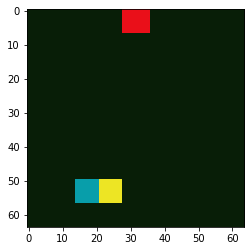

STATE: 1
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: straight
Dist proba: tf.Tensor([[9.99720175e-01 2.31525155e-05 2.56672596e-04]], shape=(1, 3), dtype=float64)
Reward: 9.393905132022553


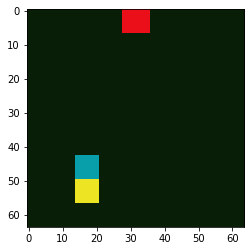

STATE: 2
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[3.27570563e-04 3.27570563e-04 9.99344859e-01]], shape=(1, 3), dtype=float64)
Reward: 2.8614529354171925


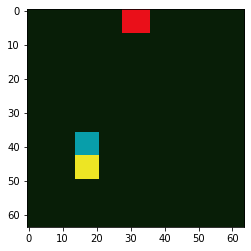

STATE: 3
Feature state :tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: straight
Dist proba: tf.Tensor([[0.9391988  0.03837238 0.02242882]], shape=(1, 3), dtype=float64)
Reward: 0.9901951359278449


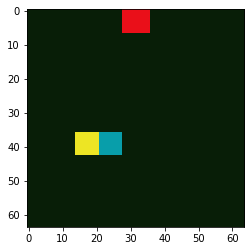

STATE: 4
Feature state :tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[1.01114379e-04 9.99868474e-01 3.04118836e-05]], shape=(1, 3), dtype=float64)
Reward: 10.0


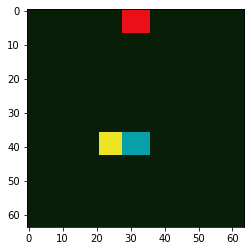

STATE: 5
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[0.20613465 0.34570605 0.44815931]], shape=(1, 3), dtype=float64)
Reward: -1.2310562561766059


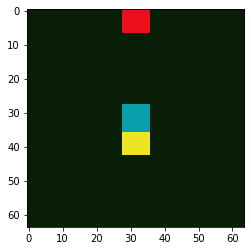

STATE: 6
Feature state :tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[1.87898433e-06 9.99996242e-01 1.87898433e-06]], shape=(1, 3), dtype=float64)
Reward: 9.608279654492812


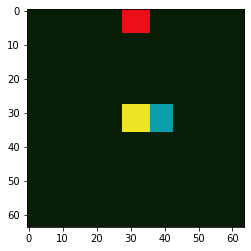

STATE: 7
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: straight
Dist proba: tf.Tensor([[9.99833022e-01 9.66379394e-05 7.03403613e-05]], shape=(1, 3), dtype=float64)
Reward: 9.262096826685898


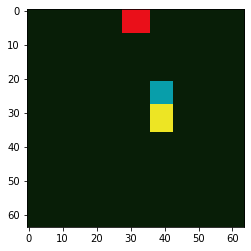

STATE: 8
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[3.97871940e-06 9.99977516e-01 1.85049623e-05]], shape=(1, 3), dtype=float64)
Reward: 2.360679774997898


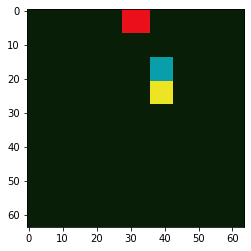

STATE: 9
Feature state :tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[3.05909376e-04 3.05909376e-04 9.99388181e-01]], shape=(1, 3), dtype=float64)
Reward: 10.0


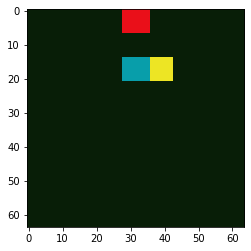

STATE: 10
Feature state :tf.Tensor([[1. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[9.99908132e-01 7.02226771e-05 2.16452458e-05]], shape=(1, 3), dtype=float64)
Reward: -4.142135623730951


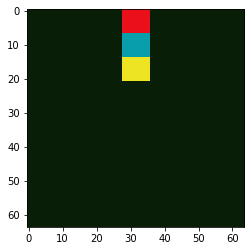

STATE: 11
Feature state :tf.Tensor([[0. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[7.31639263e-06 9.99602914e-01 3.89769772e-04]], shape=(1, 3), dtype=float64)
Reward: 4.142135623730951


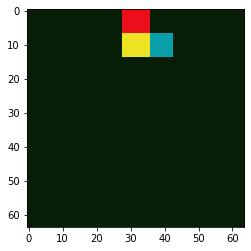

STATE: 12
Feature state :tf.Tensor([[1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[1.99996873e-05 9.99930569e-01 4.94308989e-05]], shape=(1, 3), dtype=float64)
Reward: 500


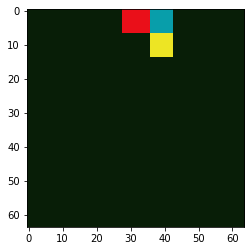

STATE: 13
Feature state :tf.Tensor([[0. 1. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[0.00371174 0.91108465 0.08520362]], shape=(1, 3), dtype=float64)
Reward: -2.360679774997898


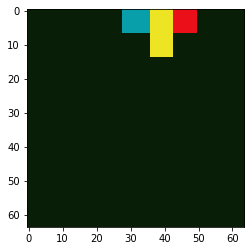

STATE: 14
Feature state :tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[4.79547096e-05 5.56041436e-06 9.99946485e-01]], shape=(1, 3), dtype=float64)
Reward: -9.262096826685898


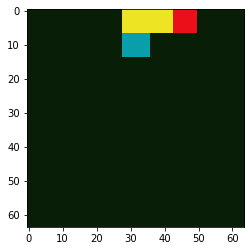

STATE: 15
Feature state :tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[2.49698087e-09 2.49698087e-09 9.99999995e-01]], shape=(1, 3), dtype=float64)
Reward: 1.6227766016837952


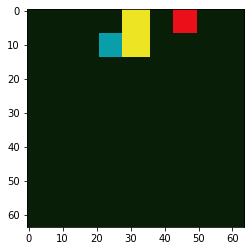

STATE: 16
Feature state :tf.Tensor([[1. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[2.69214777e-05 2.69214777e-05 9.99946157e-01]], shape=(1, 3), dtype=float64)
Reward: 10.0


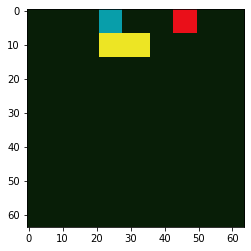

STATE: 17
Feature state :tf.Tensor([[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: straight
Dist proba: tf.Tensor([[0.32633151 0.64489859 0.02876989]], shape=(1, 3), dtype=float64)
Reward: 10.0


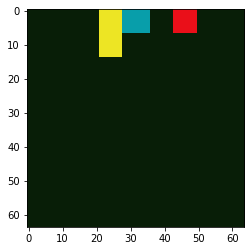

STATE: 18
Feature state :tf.Tensor([[0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 1.]], shape=(1, 12), dtype=float64)
Action: straight
Dist proba: tf.Tensor([[9.90540740e-01 6.01928318e-05 9.39906731e-03]], shape=(1, 3), dtype=float64)
Reward: 500


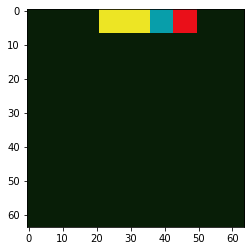

STATE: 19
Feature state :tf.Tensor([[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[5.45381047e-03 4.98469023e-04 9.94047721e-01]], shape=(1, 3), dtype=float64)
Reward: 5.028986184286088


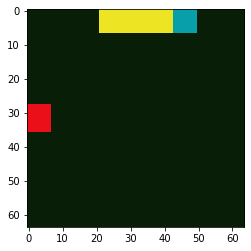

STATE: 20
Feature state :tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[4.67487493e-04 6.36149364e-05 9.99468898e-01]], shape=(1, 3), dtype=float64)
Reward: 8.772520376540687


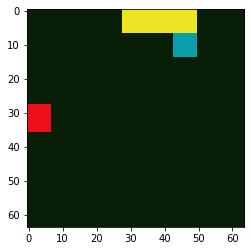

STATE: 21
Feature state :tf.Tensor([[0. 1. 0. 0. 1. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[3.96700142e-06 9.99992066e-01 3.96700142e-06]], shape=(1, 3), dtype=float64)
Reward: 4.45787087710797


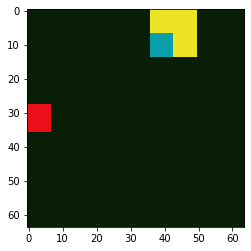

STATE: 22
Feature state :tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[0.00131326 0.03458016 0.96410658]], shape=(1, 3), dtype=float64)
Reward: 9.130288521349241


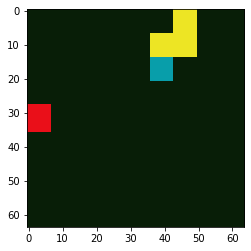

STATE: 23
Feature state :tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[2.32324996e-07 9.99993713e-01 6.05457077e-06]], shape=(1, 3), dtype=float64)
Reward: 3.4903032938191902


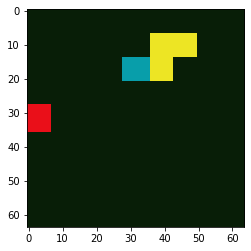

STATE: 24
Feature state :tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: right
Dist proba: tf.Tensor([[4.95357946e-07 1.55100930e-06 9.99997954e-01]], shape=(1, 3), dtype=float64)
Reward: 9.608279654492812


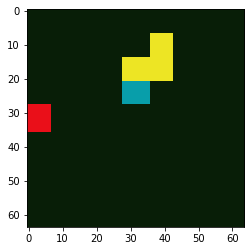

STATE: 25
Feature state :tf.Tensor([[0. 1. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[1.88114480e-04 7.77869534e-01 2.21942352e-01]], shape=(1, 3), dtype=float64)
Reward: 1.6227766016837952


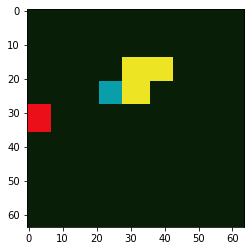

STATE: 26
Feature state :tf.Tensor([[0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[2.35698928e-05 9.99618210e-01 3.58220003e-04]], shape=(1, 3), dtype=float64)
Reward: -10.0


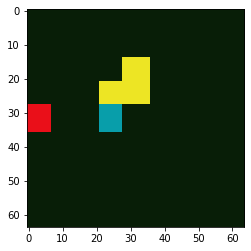

STATE: 27
Feature state :tf.Tensor([[0. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0.]], shape=(1, 12), dtype=float64)
Action: left
Dist proba: tf.Tensor([[1.79389052e-04 9.93988583e-01 5.83202831e-03]], shape=(1, 3), dtype=float64)
Reward: -100


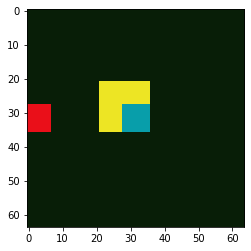

DEAD at state t=28 with score=1004.912124402085 with length Snake=4
tested


In [363]:
agent.run(pretty_display=True, debug=True, inference=True)
print("tested")